В данном ноутбуке представлены эксперименты с обычными полносвязными нейросетями.

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from gensim.models import word2vec
from pymorphy3 import MorphAnalyzer
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from navec import Navec
import gensim.downloader as api
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import seaborn as sns
import warnings

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

RANDOM_STATE = 41825352

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision('medium')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Предобработаем тексты пресс-релизов.

In [3]:
# инициализируем лемматизатор
mystem = Mystem()

# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))


# функция для препроцессинга текста
def preprocessor(text):

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем все символы, кроме пробелов и русских букв.
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)

    # лемматизируем тексты
    text = " ".join(mystem.lemmatize(text))

    # удаляем стоп-слова
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text


Xpreproc = X.release.apply(preprocessor)

Кодируем тексты при помощи TF-IDF:

In [4]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=8)
tf_idf = vectorizer.fit_transform(Xpreproc).todense()

Подготавливаем тензоры и отправляем их на GPU:

In [5]:
target_enc = LabelEncoder()
y_enc = target_enc.fit_transform(y)

data1 = torch.tensor(tf_idf, dtype=torch.float).to(device)
y1 = torch.tensor(y_enc, dtype=torch.long).to(device)

Попробуем обычную MLP с двумя скрытыми слоями, функцией активацией ReLU и dropout:

In [6]:
class TfIdfClassifier(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, out_classes),
            nn.Softmax()
        )

    def forward(self, x):
        return self.classifier(x)

Создаем и обучаем сеть:

In [7]:
def train(X, y, num_epochs, factory, start_from=30):
    y_preds = []
    y_preds_proba = []

    prog = tqdm(range(start_from, len(y)))
    for threshold in prog:
        ds = TensorDataset(X[:threshold], y[:threshold])
        dl = DataLoader(ds, 32, shuffle=False)
        
        model, optimizer, scheduler = factory()
        model.to(device)
        loss_function = nn.CrossEntropyLoss()

        model.train()
        for epoch in range(num_epochs):
            loss = None
            for bx, by in dl:
                model.zero_grad()
                probs = model(bx)
                loss = loss_function(probs, by)
                loss.backward()
                optimizer.step()
            
            if scheduler:
                scheduler.step()
            
            if epoch % 20 == 0:
                with torch.no_grad():
                    prog.set_postfix_str(f'loss = {loss.item() if loss else 0}, lr = {optimizer.param_groups[0]['lr']}')

        model.eval()
        with torch.no_grad():
            probs = model(X[threshold:threshold+1])
            pred = torch.argmax(probs)
            y_preds_proba.append(probs.detach().cpu().numpy().reshape(-1))
            y_preds.append(pred.detach().cpu().numpy().item())

    return np.array(y_preds), np.array(y_preds_proba)

In [8]:
def create_model():
    model = TfIdfClassifier(data1.shape[1], 3)
    optimizer = optim.Adam(model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[250, 400])
    return model, optimizer, scheduler

num_epochs = 500
y_preds, y_preds_proba = train(data1, y1, num_epochs, create_model)

100%|██████████| 70/70 [01:19<00:00,  1.14s/it, loss = 0.5514447689056396, lr = 1e-05] 


Посмотрим на метрики:

In [9]:
def print_metrics(name, y, y_preds, y_preds_proba, start_from=30):
    y = y[start_from:]
    acc = accuracy_score(y, y_preds)
    f1 = f1_score(y, y_preds, average="macro")
    recall = recall_score(y, y_preds, average="macro")
    precision = precision_score(y, y_preds, average="macro")
    roc_auc_ovr = roc_auc_score(y, y_preds_proba, average="macro", multi_class="ovr")
    roc_auc_ovo = roc_auc_score(y, y_preds_proba, average="macro", multi_class="ovo")

    print(classification_report(y, y_preds))
    cm = confusion_matrix(y, y_preds)
    cm = pd.DataFrame(cm, index=["-1", "0", "1"], columns=["-1", "0", "1"])
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return pd.DataFrame({
        'accuracy': acc,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'roc_auc_ovr': roc_auc_ovr,
        'roc_auc_ovo': roc_auc_ovo,
        }, index=[name])

              precision    recall  f1-score   support

        -1.0       0.75      0.78      0.77        23
         0.0       0.62      0.57      0.59        28
         1.0       0.65      0.68      0.67        19

    accuracy                           0.67        70
   macro avg       0.67      0.68      0.68        70
weighted avg       0.67      0.67      0.67        70



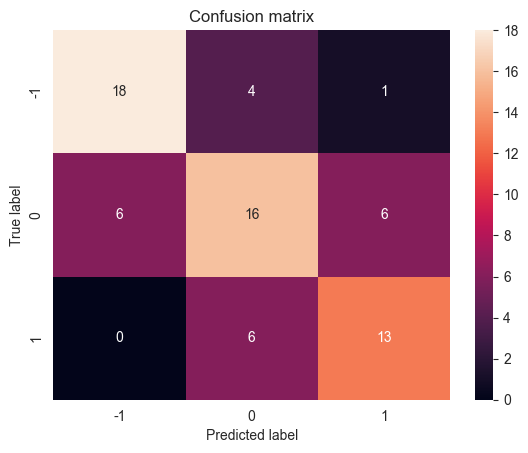

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
MLP TF-IDF,0.671429,0.675072,0.679416,0.671795,0.755827,0.759868


In [10]:
metrics = print_metrics('MLP TF-IDF', y, target_enc.inverse_transform(y_preds), y_preds_proba)
metrics

Качество предсказаний не слишком высокое.

Как и в классических моделях, добавим отбор признаков с помощью логистической регрессии и L1-регуляризации.

In [11]:
def train(X, y, num_epochs, factory, start_from=30):
    y_preds = []
    y_preds_proba = []

    prog = tqdm(range(start_from, len(y)))
    for threshold in prog:
        estimator = LogisticRegression(
            penalty="l1", solver="liblinear", C=200, max_iter=1000, random_state=RANDOM_STATE
        )
        selector = SelectFromModel(estimator, max_features=250)
        X_sel = selector.fit_transform(X[:threshold].cpu().numpy(), y[:threshold].cpu().numpy())

        ds = TensorDataset(torch.tensor(X_sel).to(device), y[:threshold])
        dl = DataLoader(ds, 32, shuffle=False)
        
        model, optimizer, scheduler = factory(X_sel.shape[1])
        model.to(device)
        loss_function = nn.CrossEntropyLoss()

        model.train()
        for epoch in range(num_epochs):
            loss = None
            for bx, by in dl:
                model.zero_grad()
                probs = model(bx)
                loss = loss_function(probs, by)
                loss.backward()
                optimizer.step()
            
            if scheduler:
                scheduler.step()
            
            if epoch % 20 == 0:
                with torch.no_grad():
                    prog.set_postfix_str(f'loss = {loss.item() if loss else 0}, lr = {optimizer.param_groups[0]['lr']}')

        model.eval()
        with torch.no_grad():
            X_eval = selector.transform(X[threshold:threshold+1].cpu().numpy())
            probs = model(torch.tensor(X_eval).to(device))
            pred = torch.argmax(probs)
            y_preds_proba.append(probs.detach().cpu().numpy().reshape(-1))
            y_preds.append(pred.detach().cpu().numpy().item())

    return np.array(y_preds), np.array(y_preds_proba)

In [12]:
def create_model(size):
    model = TfIdfClassifier(size, 3)
    optimizer = optim.Adam(model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[250, 400])
    return model, optimizer, scheduler

num_epochs = 500
y_preds, y_preds_proba = train(data1, y1, num_epochs, create_model)

100%|██████████| 70/70 [01:18<00:00,  1.13s/it, loss = 0.5514447689056396, lr = 1e-05] 


              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70        23
         0.0       0.57      0.57      0.57        28
         1.0       0.58      0.58      0.58        19

    accuracy                           0.61        70
   macro avg       0.62      0.62      0.62        70
weighted avg       0.61      0.61      0.61        70



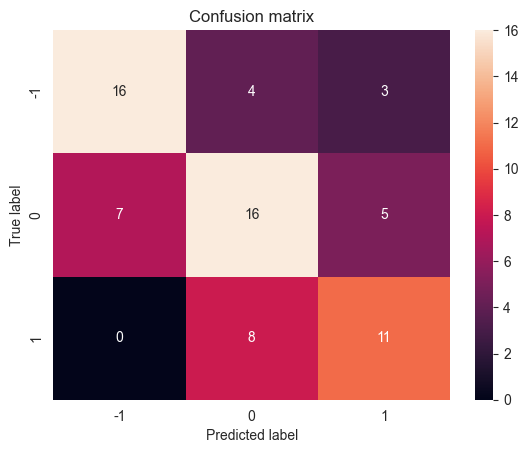

In [13]:
metric = print_metrics('MLP TF-IDF + feature selection', y, target_enc.inverse_transform(y_preds), y_preds_proba)

In [14]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
MLP TF-IDF,0.671429,0.675072,0.679416,0.671795,0.755827,0.759868
MLP TF-IDF + feature selection,0.614286,0.615343,0.615343,0.615343,0.715193,0.717330


Добавление отбора признаков ухудшает качество модели.

In [15]:
metrics.to_csv('metrics.csv')